In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.applications.resnet_v2 import ResNet50V2
from keras import callbacks
from keras import optimizers, regularizers
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session

import os, shutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
DATA_DIR = '../input/mds-misis-dl-car-classificationn/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/test_upload')
PATH = 'models/'

IMAGE_SIZE = [250, 250]
IMAGE_CHANEL = [3]
INPUT_SHAPE = IMAGE_SIZE + IMAGE_CHANEL
CLASS_NUM = 10
RANDOM_SEED = 111
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

In [3]:
train_data = pd.read_csv(DATA_DIR + 'train.csv')
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample-submission.csv'))

In [4]:
train_datagen = ImageDataGenerator( 
    rotation_range=30, 
    width_shift_range=0.1, 
    height_shift_range=0.1, #
    brightness_range=[0.8, 1.3], 
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1/255,
    preprocessing_function=None, 
    validation_split=VALIDATION_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1/255)

In [5]:
train = train_datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR, # путь до директории
    shuffle=True, #перемешивать ли данные
    target_size=IMAGE_SIZE, #целевой размер изображений на выходе генератора
    batch_size=BATCH_SIZE, #размер батча
    seed=RANDOM_SEED, #зерно датчика случайных чисел
    class_mode='categorical', #какого типа классы изображений
    subset='training' #указываем, что выборка тренировочная
)

val = train_datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    seed=RANDOM_SEED,
    class_mode='categorical', 
    subset='validation' #указываем, что выборка валидационная
)

test= test_datagen.flow_from_dataframe(
    dataframe=submission,
    directory=TEST_DATA_DIR,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [6]:
base_model = ResNet50V2(
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    include_top=False
    )

2022-04-15 14:18:03.057479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 14:18:03.176400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 14:18:03.177132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 14:18:03.178210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step


In [7]:
model = Sequential([
    base_model,
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation=None, kernel_regularizer=regularizers.l2(l2=0.001)),
    BatchNormalization(),
    LeakyReLU(0.1),
    Dropout(0.2),
    Dense(256, activation=None, kernel_regularizer=regularizers.l2(l2=0.001),),
    BatchNormalization(),
    LeakyReLU(0.1),
    Dropout(0.2),
    Dense(CLASS_NUM, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         9437696   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

In [8]:
lr = 0.0001
epochs = 5
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(lr=lr), metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
history = model.fit(train, validation_data = val, epochs = epochs, batch_size = BATCH_SIZE,)

2022-04-15 14:18:09.361819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-15 14:18:16.046110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 407s 1s/step - loss: 1.8148 - accuracy: 0.6558 - val_loss: 1.3496 - val_accuracy: 0.8144
Epoch 2/5
390/390 [==============================] - 328s 840ms/step - loss: 1.2376 - accuracy: 0.8534 - val_loss: 1.3109 - val_accuracy: 0.8286
Epoch 3/5
390/390 [==============================] - 329s 842ms/step - loss: 1.0997 - accuracy: 0.8864 - val_loss: 1.0667 - val_accuracy: 0.8916
Epoch 4/5
390/390 [==============================] - 330s 846ms/step - loss: 1.0160 - accuracy: 0.9040 - val_loss: 1.2520 - val_accuracy: 0.8215
Epoch 5/5
390/390 [==============================] - 338s 865ms/step - loss: 0.9588 - accuracy: 0.9088 - val_loss: 1.0216 - val_accuracy: 0.8839


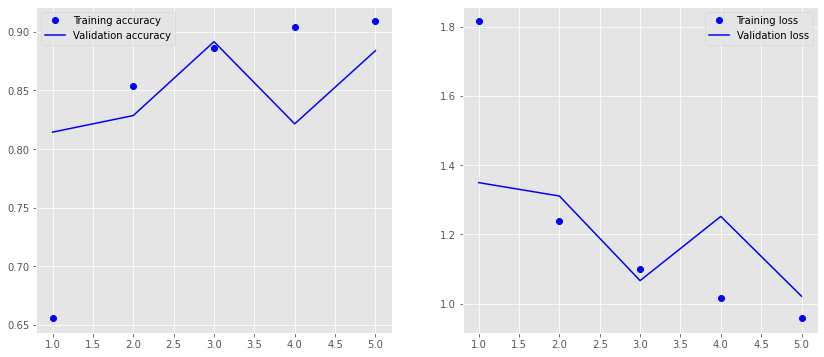

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

In [11]:
predictions = model.predict(test, verbose=1) #предсказываем вероятности принадлежности классов для каждого изображения из test_ds
predictions = np.argmax(predictions, axis=-1) #берем индекс наибольшего значения этих вероятностей
predictions

209/209 [==============================] - 78s 370ms/step


array([2, 6, 4, ..., 1, 3, 4])

In [12]:
label= dict((v,k) for k,v in train.class_indices.items()) #flip k,v
predictions = [label[k] for k in predictions]

In [13]:
submission = submission.copy()
submission['Category'] = pd.Series(predictions)
submission.to_csv('ResNet50V2_1.csv', index=False)